# Potato Leafs Disease Detection Model Training - **VGG-19**

**Import Libraries:**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

**Paths to dataset**

In [ ]:
train_dir = "/content/potato-1/train"
test_dir = "/content/potato-1/test"

# Parameters

In [10]:
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(os.listdir(train_dir))

# Count original dataset size

In [ ]:
original_train_size = sum([len(files) for _, _, files in os.walk(train_dir)])
original_test_size = sum([len(files) for _, _, files in os.walk(test_dir)])
print(f"Original Training Dataset Size: {original_train_size} images")
print(f"Original Testing Dataset Size: {original_test_size} images")

Original Training Dataset Size: 4998 images
Original Testing Dataset Size: 705 images


# Data augmentation and preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 4998 images belonging to 3 classes.
Found 705 images belonging to 3 classes.


# Checking the Available Classes

In [13]:
class_names = train_data.class_indices
n_classes = len(class_names)
print(n_classes, class_names)

3 {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


# VGG-19 model Architecture

In [ ]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Compile model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks: Early stopping and learning rate scheduler

In [16]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train model

In [18]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 530ms/step - accuracy: 0.7967 - loss: 0.4684 - val_accuracy: 0.8652 - val_loss: 0.3576 - learning_rate: 6.2500e-05
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 511ms/step - accuracy: 0.8053 - loss: 0.4397 - val_accuracy: 0.8652 - val_loss: 0.3501 - learning_rate: 6.2500e-05
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 496ms/step - accuracy: 0.7965 - loss: 0.4744 - val_accuracy: 0.8738 - val_loss: 0.3483 - learning_rate: 6.2500e-05
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 502ms/step - accuracy: 0.8006 - loss: 0.4780 - val_accuracy: 0.8738 - val_loss: 0.3506 - learning_rate: 6.2500e-05
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.8021 - loss: 0.4899 - val_accuracy: 0.8652 - val_loss: 0.3591 - learning_rate: 6.2500e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.8000 - loss: 0.4647 - val_accuracy: 0.8695 - val_loss: 0.3477 - learning_rate: 6.2500e-05
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 49

# Save model and training history

In [19]:
model.save("vgg19_potato_model.keras")
np.save("vgg19_history.npy", history.history)

# Evaluate model

In [21]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8273 - loss: 0.3861
Test Accuracy: 86.95%


# Confusion matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step


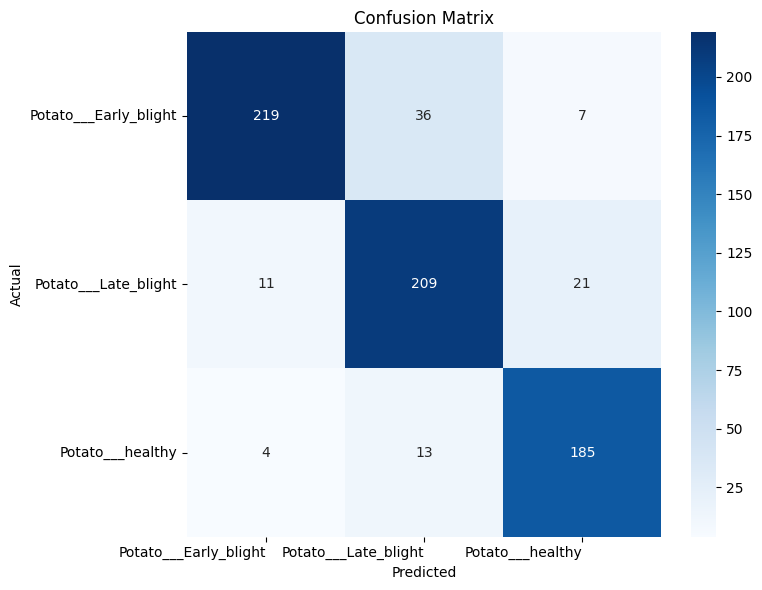

In [ ]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=360, ha='right')
plt.yticks(rotation=360, ha='right')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# Classification report

In [23]:
report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())
print(report)

                       precision    recall  f1-score   support

Potato___Early_blight       0.94      0.84      0.88       262
 Potato___Late_blight       0.81      0.87      0.84       241
     Potato___healthy       0.87      0.92      0.89       202

             accuracy                           0.87       705
            macro avg       0.87      0.87      0.87       705
         weighted avg       0.87      0.87      0.87       705



# Model predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


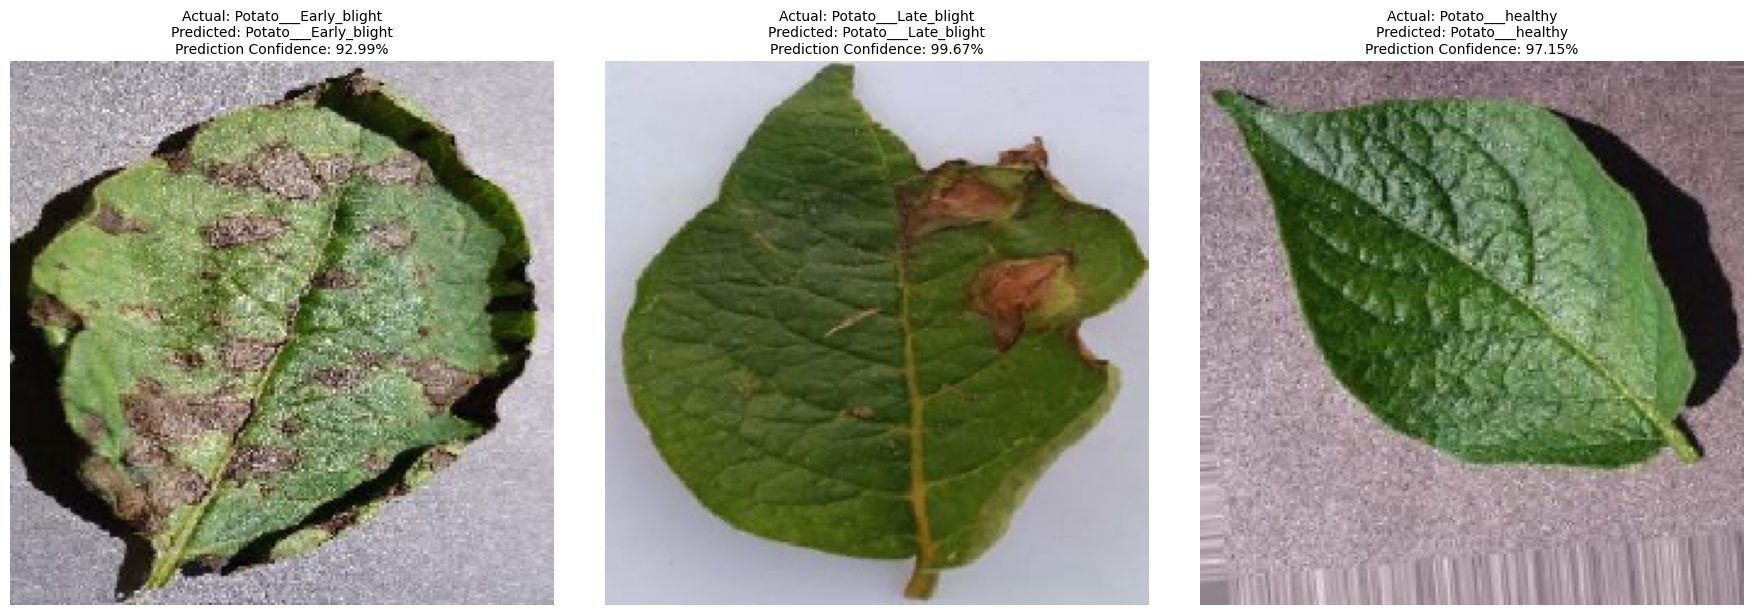

In [ ]:
def predict_random_images(model, test_dir, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}
    selected_classes = random.sample(os.listdir(test_dir), 3)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, class_name in zip(axes, selected_classes):
        class_dir = os.path.join(test_dir, class_name)
        image_files = os.listdir(class_dir)
        img_name = random.choice(image_files)
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        ax.imshow(img)
        ax.set_title(f"Actual: {class_name}\nPredicted: {predicted_class}\nPrediction Confidence: {confidence:.2f}%", fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.savefig("predictions_VGG-19.png", bbox_inches="tight")
    plt.show()
predict_random_images(model, test_dir, test_data.class_indices)